In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
#import scipy as sp
import scipy.stats as sp
import scipy as sc
import math
import numpy as np
import networkx as nx
import sys
from scipy.sparse import random

# NPN

In [2]:
def huge_npn(x,npn_func = "shrinkage",npn_thresh= None,verbose=True):
    """Implements the Gausianization to help relax the assumption of normality
    as in paper 'The Nonparanormal:Semiparametric Estimation
    of High Dimensional Undirected Graphs' Liu et.al 2009"""
    n,d = x.shape
    x_col = list(x.columns)
    x_row = list(x.index)
    if npn_func == "shrinkage":
        if verbose==True:
            print("Conducting the nonparanormal (npn) transformation via shrunkun ECDF..")
        x= sp.norm.ppf(x.apply(sp.rankdata)/(n+1))
        x = pd.DataFrame(x,columns=x_col,index=x_row)
        x = x/x.ix[:,0].std()
        if verbose==True:
            print("done.\\n")
        del(n,d,verbose)
        gc.collect()
        x.columns=x_col
        x.index = x_row
    if (npn_func =="truncation"):
        if verbose==True:
            print("Conducting nonparanormal (npn) transformation via truncated ECDF")
        if npn_thresh == None:
            npn_thresh = 1/(4*(n**0.25)* math.sqrt(math.pi*math.log(n)))
        x = sp.norm.ppf(np.minimum(np.maximum(x.apply(sp.rankdata)/n,npn_thresh),
                        1-npn_thresh))
        x = pd.DataFrame(x,columns=x_col,index=x_row)
        x = x/x.ix[:,0].std()
        if verbose== True:
            print("done.\\n")
        del(n,d,verbose)
        gc.collect()
        x.columns=x_col
        x.index = x_row
    if npn_func =="skeptic":
        if verbose == True:
            print("Conducting nonparanormal (npn) transformation via skeptic ..")
        rho, pval = sp.spearmanr(x, axis=0)    
        x = np.multiply(2,np.sin(np.multiply(math.pi/6 ,rho)))
        x = pd.DataFrame(x,columns=x_col)
        if verbose==True:
            print("done.\\n")
        del(n,d,verbose)
        gc.collect()
        x.columns=x_col
    return(x)
            

# Generate Random Graph 

In [3]:
def wgtMatrix(g,transpose=True):
    res =nt.adjacency_matrix(g, nodelist=None)
    res =res.todense()
    if transpose ==True:
        res=np.transpose(res)
    else: res
    return(res)

In [4]:
def trueCov(dag):
    wm = wgtMatrix(dag)
    p = len(dag.nodes())
    diag = np.zeros((p, p), int)
    np.fill_diagonal(diag, 1)
    mat =np.linalg.inv(diag-wm)
    cov=np.matmul(mat,np.transpose(mat))
    return(cov)

In [66]:
def erDAG(n,p):
    """Generate Random Erdos Graph as in
    Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959)"""
    mat = np.empty((n,n,))
    mat[:] = np.nan
    Q = np.triu(mat,1)
    Q[np.isnan(Q)] = np.random.binomial(1, p, (n-1)*int(n/2))
    return(Q)

In [6]:
def randDAG(n,p):
    amat= erDAG(n,p)
    G=nx.from_numpy_matrix(amat,create_using=nx.DiGraph())
    result ={"amat":amat,"G":G}
    return(result)

# GAUSSCITEST

In [7]:
def gaussCItest(x,y,S,suffStat):
    """use zStat() to test for (conditional) independence between gaussian
        random variables"""
    z = zStat(x,y,S,C = suffStat["C"], n=suffStat["n"])
    return (2*(1-sp.norm.cdf(abs(z))))

In [8]:
def log_q1pm(r):
    return (math.log1p(2*r/(1-r)))

In [9]:
def zStat(x,y,S,C,n):
    r = pcorOrder(x,y,S,C,n)
    if type(S)== int:
         res = math.sqrt(n-1-3)*0.5*log_q1pm(r)
    else:
        res = math.sqrt(n-len(S)-3)*0.5*log_q1pm(r)
    if res == np.nan:
        res = 0
    else: res =res
    return res

In [10]:
def pcorOrder(i,j,k,C,cut_at=0.9999999):
    """This function computes partial correlations given a correlation
    matrix using a recursive algorithm."""
    if k==0:
        r= C[i,j]
    elif (type(k)== int) :
        r = (C[i,j] - C[i,k] *C[j,k])/math.sqrt((1-C[j,k]**2)*(1-C[i,k]**2))
    elif len(k)==0:
        r= C[i,j]
    else:
        PM = np.linalg.pinv(C[np.ix_(np.r_[i,j,k],np.r_[i,j,k])])
        r = -PM[0,1]/math.sqrt(PM[0,0]*PM[1,1])
    if r ==  np.isnan:
        r =0
    else:
        r =min(cut_at,max(-cut_at,r))
    return(r)
            

# Simulate VAR

In [48]:

def companionVAR(A): 
    """This function transforms VAR(P) into VAR(1)"""
    A         = A
    K         = A.shape[0]
    p         = int(A.shape[1]/K)
    companion = np.zeros((K*p,K*p))
    companion[0:K,0:(K*p)] = A
    diag = np.zeros((K*p-K-1,K*p-K-1))
    np.fill_diagonal(diag, 1)
    if (p > 1):
        companion[(K):(K*p-1),0:(K*p-K-1)] = diag
    eigens    = sc.linalg.eig(companion)[0]
    mods      = abs(eigens)
    result    = {"coefMatr":A, "isCausal":max(mods) < 1, "companion":companion,
                 "eigens":eigens, "mods":mods}
    return(result)

In [49]:
def makecausal(x):
    """This function transforms VAR(P) into VAR(1) and makes
    coefficient function CAUSAL by deviding to max singular
    value"""
    A =x
    epsilion <- 0.05
    u ,singular, v= np.linalg.svd(A,full_matrices=True)
    new_singular <-singular/(max(singular)+epsilion)
    diag = np.zeros((len(singular),len(singular)))
    np.fill_diagonal(diag, new_singular)
    A = np.matrixmultiply(np.matrixmultiply(u,diag),np.transpose(v))
    companion = np.zeros((K*p,K*p))
    companion[0:K-1,0:(K*p-1)] = A
    diag1 = np.zeros((K*p-K-1,K*p-K-1))
    np.fill_diagonal(diag1, 1)
    if (p>1):
        companion[(K):(K*p-1),0:((K*p)-K-1)] = diag1
    eigens    = sc.linalg.eig(companion)[0]
    mods      = abs(eigens)
    return({"companion":companion,"mods":mods})

In [50]:
def coeffmat(K=2,p=1,seed=10 ):
    random.seed(seed)
#  K=K
#  p=p
    A = random(K,(K*p),density=0.4)
    companion              = np.zeros((K*p,K*p))
    companion[0:K-1,0:(K*p-1)] = A
    diag1 = np.zeros((K*p-K-1,K*p-K-1))
    np.fill_diagonal(diag1, 1)
    if (p>1):
        companion[(K):(K*p-1),0:((K*p)-K-1)] = diag1
    eigens    = sc.linalg.eig(companion)[0]
    mods      = abs(eigens)
    isCausal = max(mods) < 1
    if (isCausal==False):
        companion =makecausal(A)["companion"]
        isCausal = max(makecausal(A)["mods"]) <1
        A=companion[0:K-1,0:(K*p-1)] 
    result=list(A= A,companion=companion, isCausal=isCausal)
    return(result)


In [51]:
diag = np.zeros((3,3))
np.fill_diagonal(diag, [0,3,5])
diag

array([[0., 0., 0.],
       [0., 3., 0.],
       [0., 0., 5.]])

In [52]:
coeffmat(3,2,10)

AttributeError: 'function' object has no attribute 'seed'

In [53]:
A

matrix([[0, 0, 1, 1, 0, 1],
        [0, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0]])

In [54]:
A=np.matrix([[0,0,1,1,0,1],
           [0,0,1,1,0,1],
           [0,0,0,0,1,0]])

companionVAR(A)

{'coefMatr': matrix([[0, 0, 1, 1, 0, 1],
         [0, 0, 1, 1, 0, 1],
         [0, 0, 0, 0, 1, 0]]),
 'isCausal': False,
 'companion': array([[0., 0., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 'eigens': array([ 1.32471796+0.j        , -0.66235898+0.56227951j,
        -0.66235898-0.56227951j,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ]),
 'mods': array([1.32471796, 0.86883696, 0.86883696, 0.        , 0.        ,
        0.        ])}

In [55]:
diag = np.zeros((K*p-K-1,K*p-K-1))
np.fill_diagonal(diag, 1)
diag

NameError: name 'K' is not defined

In [60]:
def simulateVAR(coefMatr=None,intercept,size,burn=100,Sigma,error_dist,df=None,checkCausal=True):
   
    if coefMatr is not None:
        coefMatr = coefMatr
    inteVect    = intercept
    #inteVect    = matrix(inteVect,ncol=1) Command was in actual code
    K           = Sigma.shape[0]
    print(K)
    if error_dist=="t":
        if df is None or df<=2:
            sys.exit()
            print("error: the d.f. of t-distribution is NULL or <=2")
    if (min(sc.linalg.eig(Sigma)[0])<0):
        sys.exit()
        print("error: the covariance matrix is not positive-definite")
    if (isnull(coefMatr)): 
        if(checkCausal & companionVAR(coefMatr).isCausal){stop("error: the VAR model is non-causal")}
    
    S.scale        = diag(NA,K) 
    if(error.dist=="t"):
        S.scale = Sigma*(df-2)/df
    if (is.null(coefMatr)):
        p = ncol(coefMatr)/K 
    else:
        p=0
    simData        = matrix(NA,nrow=K,ncol=size+burn)
    cholSigma      = t(chol(Sigma))
    if(p!=0):
        simData[,1:p]  = matrix(rnorm(K*p),nrow=K,ncol=p)
        for (i in (p+1):(size+burn)){
                if (error.dist=="normal") {error = cholSigma %*% matrix(rnorm(K),ncol=1)}
            if (error.dist=="t")      {error = matrix(rmt(n=1,rep(0,K),S.scale,df),ncol=1)}
            simData[,i] = inteVect + coefMatr %*% matrix(c(simData[,(i-1):(i-p)]),ncol=1) + error
    }
    if(p==0){
        for (i in (p+1):(size+burn)){
            if (error.dist=="normal") {error = cholSigma %*% matrix(rnorm(K),ncol=1)}
            if (error.dist=="t")      {error = matrix(rmt(n=1,rep(0,K),S.scale,df),ncol=1)}
            simData[,i] = inteVect + error
    }}
    simData  = t(simData[,(1+burn):(size+burn)])
    result   = list(simData=simData,coefMatr=coefMatr,inteVect=inteVect,K=K,p=p,size=size,checkCausal=checkCausal,Sigma=Sigma,error.dist=error.dist,df=df)
    return(result)
 }

SyntaxError: invalid syntax (<ipython-input-60-d453f8a80010>, line 17)

# Example of changing truecov function

In [61]:
A=np.matrix([[0,0,1,1,0,1],
           [0,0,1,1,0,1],
           [0,0,0,0,1,0],
           [0,0,0,0,1,1],
           [0,0,0,0,0,0],
            [0,0,0,0,0,0]])
G=nx.from_numpy_matrix(A,create_using=nx.DiGraph())
#trueCov(G)

In [62]:
abs(sc.linalg.eig(A)[0])

array([0., 0., 0., 0., 0., 0.])

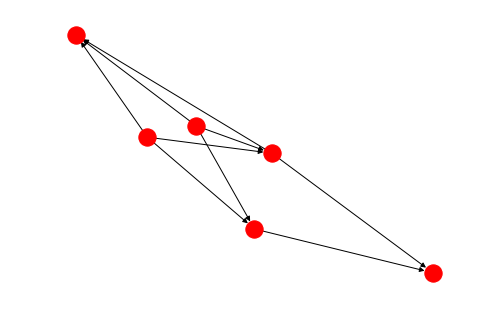

In [63]:
nx.draw(G)
plt.show()

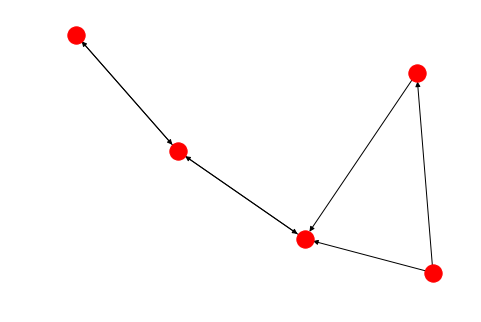

In [64]:
g= nx.gnp_random_graph(5, 0.4, seed=10, directed=True)
nx.draw(g)
plt.show()

In [67]:
nx.draw(randDAG(5,0.2)["G"])
plt.show()

ValueError: NumPy boolean array indexing assignment cannot assign 8 input values to the 10 output values where the mask is true

In [13]:
import os
path = "C:\\Users\\dallakyan1988\\Documents\\Nonparanormal"
os.chdir(path)

In [23]:
data = pd.read_csv("GaussCItest_Example.csv",sep =",",usecols=["x","y","z"] )

In [69]:
data.head()

,x,y,z
0,-1.283371,-3.761766,-8.335365
1,-1.263450,-3.252096,-5.311136
2,0.214673,-0.884848,-1.424593
3,0.946949,1.550440,2.108790
4,-1.175025,-2.739191,-7.253134


In [195]:
suffStat = {"C":np.corrcoef(data, rowvar=False), "n" :data.shape[0]}

In [197]:
suffStat["n"]

100

In [194]:
C= np.corrcoef(data, rowvar=False)

In [228]:
gaussCItest(0,2,0, suffStat)

0.0

In [166]:
C[np.ix_([0+[1,2]],[0+[1,2]])]
np.r_()

TypeError: unsupported operand type(s) for +: 'int' and 'list'